In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from collections import Counter
import re
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# **PART 1: DATA LOADING AND PREPROCESSING**

In [18]:
class TRECDataProcessor:
    """Handles TREC dataset loading, preprocessing, and tokenization"""

    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.vocab = {}
        self.idx2word = {}
        self.word2idx = {}
        self.label2idx = {}
        self.idx2label = {}

    def load_data(self):
        """Load train and test data"""
        print("Loading data...")
        train_df = pd.read_csv(self.train_path)
        test_df = pd.read_csv(self.test_path)

        # Assuming columns are 'label' and 'text' or similar
        # Adjust column names based on your CSV structure
        if 'label-coarse' in train_df.columns:
            train_df = train_df.rename(columns={'label-coarse': 'label', 'text': 'text'})
            test_df = test_df.rename(columns={'label-coarse': 'label', 'text': 'text'})

        print(f"Train samples: {len(train_df)}")
        print(f"Test samples: {len(test_df)}")

        return train_df, test_df

    def exploratory_analysis(self, train_df, test_df):
        """Perform EDA and generate statistics"""
        print("\n" + "="*60)
        print("EXPLORATORY DATA ANALYSIS")
        print("="*60)

        # Class distribution
        print("\nClass Distribution (Train):")
        class_dist = train_df['label'].value_counts()
        print(class_dist)

        # Text length statistics
        train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))
        test_df['text_length'] = test_df['text'].apply(lambda x: len(str(x).split()))

        print(f"\nText Length Statistics (Train):")
        print(f"Mean: {train_df['text_length'].mean():.2f}")
        print(f"Median: {train_df['text_length'].median():.2f}")
        print(f"Max: {train_df['text_length'].max()}")
        print(f"Min: {train_df['text_length'].min()}")

        # Visualizations
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Class distribution
        class_dist.plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title('Class Distribution')
        axes[0].set_xlabel('Class')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45)

        # Text length distribution
        axes[1].hist(train_df['text_length'], bins=30, color='coral', edgecolor='black')
        axes[1].set_title('Text Length Distribution')
        axes[1].set_xlabel('Number of Words')
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
        print("\nEDA visualization saved as 'eda_analysis.png'")

        return train_df, test_df

    def preprocess_text(self, text):
        """Clean and preprocess text"""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def build_vocabulary(self, texts, min_freq=2):
        """Build vocabulary from texts"""
        print("\nBuilding vocabulary...")

        # Tokenize and count
        word_counts = Counter()
        for text in texts:
            words = self.preprocess_text(text).split()
            word_counts.update(words)

        # Special tokens
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<CLS>': 2, '<SEP>': 3}
        idx = 4

        # Add words meeting minimum frequency
        for word, count in word_counts.items():
            if count >= min_freq:
                self.word2idx[word] = idx
                idx += 1

        self.idx2word = {v: k for k, v in self.word2idx.items()}

        print(f"Vocabulary size: {len(self.word2idx)}")
        print(f"Most common words: {word_counts.most_common(10)}")

        return self.word2idx

    def build_label_mapping(self, labels):
        """Create label to index mapping"""
        unique_labels = sorted(labels.unique())
        self.label2idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.idx2label = {idx: label for label, idx in self.label2idx.items()}
        print(f"\nLabel mapping: {self.label2idx}")
        return self.label2idx

    def encode_text(self, text, max_length=64):
        """Convert text to token indices"""
        words = self.preprocess_text(text).split()

        # Add CLS token at start
        indices = [self.word2idx['<CLS>']]

        # Add word indices
        for word in words[:max_length-2]:  # -2 for CLS and SEP
            indices.append(self.word2idx.get(word, self.word2idx['<UNK>']))

        # Add SEP token
        indices.append(self.word2idx['<SEP>'])

        return indices

    def prepare_datasets(self, train_df, test_df, max_length=64, val_split=0.2):
        """Prepare train, val, test datasets"""
        print("\nPreparing datasets...")

        # Build vocabulary and label mapping
        self.build_vocabulary(train_df['text'])
        self.build_label_mapping(train_df['label'])

        # Split train into train and validation
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            train_df['text'].values,
            train_df['label'].values,
            test_size=val_split,
            random_state=42,
            stratify=train_df['label'].values
        )

        print(f"Train size: {len(train_texts)}")
        print(f"Validation size: {len(val_texts)}")
        print(f"Test size: {len(test_df)}")

        # Encode texts
        train_encoded = [self.encode_text(text, max_length) for text in train_texts]
        val_encoded = [self.encode_text(text, max_length) for text in val_texts]
        test_encoded = [self.encode_text(text, max_length) for text in test_df['text'].values]

        # Encode labels
        train_labels_encoded = [self.label2idx[label] for label in train_labels]
        val_labels_encoded = [self.label2idx[label] for label in val_labels]
        test_labels_encoded = [self.label2idx[label] for label in test_df['label'].values]

        return {
            'train': (train_encoded, train_labels_encoded),
            'val': (val_encoded, val_labels_encoded),
            'test': (test_encoded, test_labels_encoded)
        }



In [19]:


class TRECDataset(Dataset):
    """PyTorch Dataset for TREC data"""

    def __init__(self, encoded_texts, labels, max_length=64):
        self.encoded_texts = encoded_texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        encoded = self.encoded_texts[idx]
        label = self.labels[idx]

        # Pad sequence
        padded = encoded + [0] * (self.max_length - len(encoded))
        padded = padded[:self.max_length]

        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1 if token != 0 else 0 for token in padded]

        return {
            'input_ids': torch.tensor(padded, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# **PART 2: TRANSFORMER ENCODER ARCHITECTURE**

In [20]:
class PositionalEncoding(nn.Module):
    """Sinusoidal Positional Encoding"""

    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [21]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention Mechanism"""

    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = np.sqrt(self.d_k)

    def forward(self, x, mask=None, return_attention=False):
        """
        Args:
            x: Input tensor (batch_size, seq_len, d_model)
            mask: Attention mask (batch_size, seq_len)
            return_attention: Whether to return attention weights
        """
        batch_size, seq_len, _ = x.size()

        # Linear projections and split into heads
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        # Apply mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to values
        context = torch.matmul(attention_weights, V)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        # Final linear projection
        output = self.W_o(context)

        if return_attention:
            return output, attention_weights
        return output


In [22]:
class FeedForward(nn.Module):
    """Position-wise Feed-Forward Network"""

    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        """
        Args:
            x: Input tensor (batch_size, seq_len, d_model)
        """
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [23]:
class EncoderLayer(nn.Module):
    """Single Transformer Encoder Layer"""

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        # Feed-forward network
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None, return_attention=False):
        """
        Args:
            x: Input tensor (batch_size, seq_len, d_model)
            mask: Attention mask
            return_attention: Whether to return attention weights
        """
        # Multi-head attention with residual connection
        if return_attention:
            attn_output, attention_weights = self.attention(x, mask, return_attention=True)
        else:
            attn_output = self.attention(x, mask)

        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))

        if return_attention:
            return x, attention_weights
        return x

In [24]:
class TransformerEncoder(nn.Module):
    """Complete Transformer Encoder for Classification"""

    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=4,
                 d_ff=1024, num_classes=6, max_len=64, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.positional_encoding = PositionalEncoding(d_model, max_len, dropout)

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, input_ids, attention_mask=None, return_attention=False):
        """
        Args:
            input_ids: Token indices (batch_size, seq_len)
            attention_mask: Attention mask (batch_size, seq_len)
            return_attention: Whether to return attention weights
        """
        # Embedding
        x = self.embedding(input_ids) * np.sqrt(self.d_model)
        x = self.positional_encoding(x)

        # Pass through encoder layers
        attention_weights_list = []
        for layer in self.encoder_layers:
            if return_attention:
                x, attn_weights = layer(x, attention_mask, return_attention=True)
                attention_weights_list.append(attn_weights)
            else:
                x = layer(x, attention_mask)

        # Use CLS token (first token) for classification
        cls_output = x[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.fc(cls_output)

        if return_attention:
            return logits, attention_weights_list
        return logits



# **PART 3: TRAINING AND EVALUATION**

In [25]:
class Trainer:
    """Training and evaluation handler"""

    def __init__(self, model, train_loader, val_loader, test_loader,
                 device, learning_rate=1e-4, num_epochs=10):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.num_epochs = num_epochs

        # Optimizer with learning rate warmup
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

        # Learning rate scheduler
        total_steps = len(train_loader) * num_epochs
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=learning_rate,
            total_steps=total_steps,
            pct_start=0.1,
            anneal_strategy='cos'
        )

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

        # Training history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': []
        }

        self.best_val_acc = 0.0

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for batch in pbar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()

            # Statistics
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })

        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct / total

        return avg_loss, accuracy

    def evaluate(self, data_loader):
        """Evaluate on validation or test set"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(data_loader, desc='Evaluating'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                logits = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels)

                total_loss += loss.item()
                predictions = torch.argmax(logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(data_loader)
        accuracy = accuracy_score(all_labels, all_predictions)

        return avg_loss, accuracy, all_predictions, all_labels

    def train(self):
        """Complete training loop"""
        print("\n" + "="*60)
        print("STARTING TRAINING")
        print("="*60)

        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.num_epochs}")
            print("-" * 60)

            # Train
            train_loss, train_acc = self.train_epoch()

            # Validate
            val_loss, val_acc, _, _ = self.evaluate(self.val_loader)

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(self.scheduler.get_last_lr()[0])

            print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_model.pt')
                print(f"✓ Best model saved! (Val Acc: {val_acc*100:.2f}%)")

        print("\n" + "="*60)
        print("TRAINING COMPLETED")
        print("="*60)

    def plot_training_history(self):
        """Plot training curves"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        epochs = range(1, len(self.history['train_loss']) + 1)

        # Loss curves
        axes[0].plot(epochs, self.history['train_loss'], 'b-', label='Train Loss', linewidth=2)
        axes[0].plot(epochs, self.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy curves
        axes[1].plot(epochs, [acc*100 for acc in self.history['train_acc']],
                    'b-', label='Train Acc', linewidth=2)
        axes[1].plot(epochs, [acc*100 for acc in self.history['val_acc']],
                    'r-', label='Val Acc', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].set_title('Training and Validation Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Learning rate schedule
        axes[2].plot(self.history['learning_rates'], 'g-', linewidth=2)
        axes[2].set_xlabel('Step')
        axes[2].set_ylabel('Learning Rate')
        axes[2].set_title('Learning Rate Schedule')
        axes[2].grid(True, alpha=0.3)
        axes[2].set_yscale('log')

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        print("\nTraining curves saved as 'training_curves.png'")

    def detailed_evaluation(self, label_names):
        """Comprehensive evaluation with metrics"""
        print("\n" + "="*60)
        print("DETAILED EVALUATION ON TEST SET")
        print("="*60)

        # Load best model
        self.model.load_state_dict(torch.load('best_model.pt'))

        # Evaluate
        test_loss, test_acc, predictions, labels = self.evaluate(self.test_loader)

        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc*100:.2f}%")

        # Detailed metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            labels, predictions, average=None, zero_division=0
        )

        print("\nPer-Class Metrics:")
        print("-" * 60)
        print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
        print("-" * 60)

        for i, label_name in enumerate(label_names):
            print(f"{label_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

        # Macro averages
        macro_precision = precision.mean()
        macro_recall = recall.mean()
        macro_f1 = f1.mean()

        print("-" * 60)
        print(f"{'Macro Avg':<15} {macro_precision:<12.4f} {macro_recall:<12.4f} {macro_f1:<12.4f}")
        print("=" * 60)

        # Confusion matrix
        cm = confusion_matrix(labels, predictions)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_names, yticklabels=label_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        print("\nConfusion matrix saved as 'confusion_matrix.png'")

        return {
            'test_acc': test_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'macro_f1': macro_f1
        }



# **PART 4: ATTENTION VISUALIZATION**

In [26]:
class AttentionVisualizer:
    """Visualize attention patterns"""

    def __init__(self, model, data_processor, device):
        self.model = model
        self.data_processor = data_processor
        self.device = device
        self.model.eval()

    def visualize_attention(self, text, layer_idx=0, head_idx=0):
        """Visualize attention for a single text sample"""
        # Encode text
        encoded = self.data_processor.encode_text(text, max_length=64)
        padded = encoded + [0] * (64 - len(encoded))
        padded = padded[:64]
        attention_mask = [1 if token != 0 else 0 for token in padded]

        # Convert to tensors
        input_ids = torch.tensor([padded], dtype=torch.long).to(self.device)
        attention_mask_tensor = torch.tensor([attention_mask], dtype=torch.long).to(self.device)

        # Get attention weights
        with torch.no_grad():
            logits, attention_weights = self.model(input_ids, attention_mask_tensor, return_attention=True)

        # Get tokens
        tokens = [self.data_processor.idx2word.get(idx, '<UNK>') for idx in padded]
        tokens = [t for t, m in zip(tokens, attention_mask) if m == 1]

        # Get attention for specific layer and head
        attn = attention_weights[layer_idx][0, head_idx].cpu().numpy()
        attn = attn[:len(tokens), :len(tokens)]

        # Plot
        fig, ax = plt.subplots(figsize=(12, 10))
        im = ax.imshow(attn, cmap='viridis', aspect='auto')

        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=90, fontsize=8)
        ax.set_yticklabels(tokens, fontsize=8)

        plt.colorbar(im, ax=ax)
        ax.set_title(f'Attention Weights - Layer {layer_idx}, Head {head_idx}')
        ax.set_xlabel('Key Tokens')
        ax.set_ylabel('Query Tokens')

        plt.tight_layout()
        return fig, attn

    def visualize_multiple_samples(self, texts, labels, predictions, num_samples=5):
        """Visualize attention for multiple samples"""
        fig, axes = plt.subplots(num_samples, 1, figsize=(14, 4*num_samples))

        if num_samples == 1:
            axes = [axes]

        for idx in range(min(num_samples, len(texts))):
            text = texts[idx]
            true_label = labels[idx]
            pred_label = predictions[idx]

            # Encode text
            encoded = self.data_processor.encode_text(text, max_length=64)
            padded = encoded + [0] * (64 - len(encoded))
            padded = padded[:64]
            attention_mask = [1 if token != 0 else 0 for token in padded]

            # Convert to tensors
            input_ids = torch.tensor([padded], dtype=torch.long).to(self.device)
            attention_mask_tensor = torch.tensor([attention_mask], dtype=torch.long).to(self.device)

            # Get attention weights
            with torch.no_grad():
                logits, attention_weights = self.model(input_ids, attention_mask_tensor, return_attention=True)

            # Get tokens
            tokens = [self.data_processor.idx2word.get(i, '<UNK>') for i in padded]
            tokens = [t for t, m in zip(tokens, attention_mask) if m == 1]

            # Average attention across all heads in last layer
            attn = attention_weights[-1][0].mean(dim=0).cpu().numpy()
            attn = attn[:len(tokens), :len(tokens)]

            # Plot
            im = axes[idx].imshow(attn, cmap='viridis', aspect='auto')
            axes[idx].set_xticks(range(len(tokens)))
            axes[idx].set_yticks(range(len(tokens)))
            axes[idx].set_xticklabels(tokens, rotation=90, fontsize=7)
            axes[idx].set_yticklabels(tokens, fontsize=7)

            status = "✓" if true_label == pred_label else "✗"
            axes[idx].set_title(f'{status} True: {true_label} | Pred: {pred_label}\nText: {text[:60]}...',
                               fontsize=9)

            plt.colorbar(im, ax=axes[idx])

        plt.tight_layout()
        plt.savefig('attention_visualization.png', dpi=300, bbox_inches='tight')
        print("\nAttention visualizations saved as 'attention_visualization.png'")



# **PART 5: ABLATION STUDY**

In [27]:
class AblationStudy:
    """Conduct ablation experiments"""

    def __init__(self, train_loader, val_loader, test_loader, vocab_size, device):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.vocab_size = vocab_size
        self.device = device
        self.results = []

    def experiment(self, config_name, d_model, num_heads, num_layers, d_ff, epochs=5):
        """Run single experiment with given configuration"""
        print(f"\n{'='*60}")
        print(f"Ablation Experiment: {config_name}")
        print(f"{'='*60}")
        print(f"Config: d_model={d_model}, heads={num_heads}, layers={num_layers}, d_ff={d_ff}")

        # Create model
        model = TransformerEncoder(
            vocab_size=self.vocab_size,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            d_ff=d_ff,
            num_classes=6,
            max_len=64,
            dropout=0.1
        )

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total Parameters: {total_params:,}")

        # Train
        trainer = Trainer(
            model, self.train_loader, self.val_loader, self.test_loader,
            self.device, learning_rate=1e-4, num_epochs=epochs
        )

        import time
        start_time = time.time()
        trainer.train()
        training_time = time.time() - start_time

        # Evaluate
        test_loss, test_acc, _, _ = trainer.evaluate(self.test_loader)

        result = {
            'config': config_name,
            'd_model': d_model,
            'num_heads': num_heads,
            'num_layers': num_layers,
            'd_ff': d_ff,
            'parameters': total_params,
            'test_accuracy': test_acc,
            'training_time': training_time,
            'best_val_acc': trainer.best_val_acc
        }

        self.results.append(result)
        print(f"\nTest Accuracy: {test_acc*100:.2f}%")
        print(f"Training Time: {training_time/60:.2f} minutes")

        return result

    def run_full_study(self):
        """Run comprehensive ablation study"""
        print("\n" + "="*60)
        print("STARTING ABLATION STUDY")
        print("="*60)

        # Baseline
        self.experiment("Baseline", d_model=256, num_heads=8, num_layers=4, d_ff=1024, epochs=5)

        # Vary number of heads
        self.experiment("4 Heads", d_model=256, num_heads=4, num_layers=4, d_ff=1024, epochs=5)
        self.experiment("16 Heads", d_model=256, num_heads=16, num_layers=4, d_ff=1024, epochs=5)

        # Vary number of layers
        self.experiment("2 Layers", d_model=256, num_heads=8, num_layers=2, d_ff=1024, epochs=5)
        self.experiment("6 Layers", d_model=256, num_heads=8, num_layers=6, d_ff=1024, epochs=5)

        # Vary model dimension
        self.experiment("d_model=128", d_model=128, num_heads=4, num_layers=4, d_ff=512, epochs=5)
        self.experiment("d_model=512", d_model=512, num_heads=8, num_layers=4, d_ff=2048, epochs=5)

        self.save_results()
        self.plot_results()

    def save_results(self):
        """Save ablation results"""
        df = pd.DataFrame(self.results)
        df.to_csv('ablation_results.csv', index=False)
        print("\n✓ Ablation results saved to 'ablation_results.csv'")

        # Print summary table
        print("\n" + "="*60)
        print("ABLATION STUDY RESULTS")
        print("="*60)
        print(df.to_string(index=False))

    def plot_results(self):
        """Plot ablation study results"""
        df = pd.DataFrame(self.results)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Accuracy comparison
        axes[0].bar(range(len(df)), df['test_accuracy']*100, color='skyblue', edgecolor='black')
        axes[0].set_xticks(range(len(df)))
        axes[0].set_xticklabels(df['config'], rotation=45, ha='right')
        axes[0].set_ylabel('Test Accuracy (%)')
        axes[0].set_title('Test Accuracy Comparison')
        axes[0].grid(axis='y', alpha=0.3)

        # Parameters vs Accuracy
        axes[1].scatter(df['parameters']/1e6, df['test_accuracy']*100, s=100, color='coral')
        for idx, row in df.iterrows():
            axes[1].annotate(row['config'], (row['parameters']/1e6, row['test_accuracy']*100),
                           fontsize=7, ha='right')
        axes[1].set_xlabel('Parameters (Millions)')
        axes[1].set_ylabel('Test Accuracy (%)')
        axes[1].set_title('Model Size vs Accuracy')
        axes[1].grid(alpha=0.3)

        # Training time comparison
        axes[2].bar(range(len(df)), df['training_time']/60, color='lightgreen', edgecolor='black')
        axes[2].set_xticks(range(len(df)))
        axes[2].set_xticklabels(df['config'], rotation=45, ha='right')
        axes[2].set_ylabel('Training Time (minutes)')
        axes[2].set_title('Training Time Comparison')
        axes[2].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('ablation_study.png', dpi=300, bbox_inches='tight')
        print("\n✓ Ablation study plots saved as 'ablation_study.png'")



# **MAIN EXECUTION**

In [28]:
def main():
    """Main execution function"""

    print("="*60)
    print("TRANSFORMER ENCODER FROM SCRATCH")
    print("TREC Question Classification")
    print("="*60)

    # Configuration
    CONFIG = {
        'train_path': '/content/gdrive/MyDrive/practical_data/dataset-assinment3/train.csv',
        'test_path': '/content/gdrive/MyDrive/practical_data/dataset-assinment3/test.csv',
        'd_model': 256,
        'num_heads': 8,
        'num_layers': 4,
        'd_ff': 1024,
        'max_length': 64,
        'batch_size': 32,
        'learning_rate': 1e-4,
        'num_epochs': 10,
        'dropout': 0.1
    }

    # Save configuration
    with open('config.json', 'w') as f:
        json.dump(CONFIG, f, indent=4)
    print("\n✓ Configuration saved to 'config.json'")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n✓ Using device: {device}")

    # ========================================================================
    # STEP 1: DATA PREPARATION
    # ========================================================================

    processor = TRECDataProcessor(CONFIG['train_path'], CONFIG['test_path'])
    train_df, test_df = processor.load_data()
    train_df, test_df = processor.exploratory_analysis(train_df, test_df)

    # Prepare datasets
    datasets = processor.prepare_datasets(train_df, test_df,
                                         max_length=CONFIG['max_length'])

    # Create data loaders
    train_dataset = TRECDataset(datasets['train'][0], datasets['train'][1],
                               CONFIG['max_length'])
    val_dataset = TRECDataset(datasets['val'][0], datasets['val'][1],
                             CONFIG['max_length'])
    test_dataset = TRECDataset(datasets['test'][0], datasets['test'][1],
                              CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                             shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'],
                           shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'],
                            shuffle=False, num_workers=0)

    print(f"\n✓ Data loaders created")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    print(f"  Test batches: {len(test_loader)}")

    # ========================================================================
    # STEP 2: MODEL CREATION
    # ========================================================================

    model = TransformerEncoder(
        vocab_size=len(processor.word2idx),
        d_model=CONFIG['d_model'],
        num_heads=CONFIG['num_heads'],
        num_layers=CONFIG['num_layers'],
        d_ff=CONFIG['d_ff'],
        num_classes=len(processor.label2idx),
        max_len=CONFIG['max_length'],
        dropout=CONFIG['dropout']
    )

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\n" + "="*60)
    print("MODEL ARCHITECTURE")
    print("="*60)
    print(model)
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

    # ========================================================================
    # STEP 3: TRAINING
    # ========================================================================

    trainer = Trainer(
        model, train_loader, val_loader, test_loader,
        device,
        learning_rate=CONFIG['learning_rate'],
        num_epochs=CONFIG['num_epochs']
    )

    trainer.train()
    trainer.plot_training_history()

    # ========================================================================
    # STEP 4: EVALUATION
    # ========================================================================

    label_names = [processor.idx2label[i] for i in range(len(processor.idx2label))]
    results = trainer.detailed_evaluation(label_names)

    # ========================================================================
    # STEP 5: ATTENTION VISUALIZATION
    # ========================================================================

    print("\n" + "="*60)
    print("ATTENTION VISUALIZATION")
    print("="*60)

    visualizer = AttentionVisualizer(model, processor, device)

    # Get some test samples for visualization
    test_texts = test_df['text'].values[:10]
    test_labels_str = [processor.idx2label[label] for label in datasets['test'][1][:10]]

    # Get predictions
    model.eval()
    sample_predictions = []
    for text in test_texts:
        encoded = processor.encode_text(text, CONFIG['max_length'])
        padded = encoded + [0] * (CONFIG['max_length'] - len(encoded))
        input_ids = torch.tensor([padded[:CONFIG['max_length']]], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(input_ids)
            pred = torch.argmax(logits, dim=1).item()
            sample_predictions.append(processor.idx2label[pred])

    visualizer.visualize_multiple_samples(test_texts, test_labels_str,
                                         sample_predictions, num_samples=5)

    # ========================================================================
    # STEP 6: ABLATION STUDY (OPTIONAL - Comment out if time is short)
    # ========================================================================

    print("\n" + "="*60)
    print("ABLATION STUDY")
    print("="*60)
    print("Running ablation study (this will take time)...")
    print("Note: You can skip this section by commenting it out if time is limited")

    # Uncomment the lines below to run ablation study
    # ablation = AblationStudy(train_loader, val_loader, test_loader,
    #                         len(processor.word2idx), device)
    # ablation.run_full_study()

    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================

    print("\n" + "="*60)
    print("ASSIGNMENT COMPLETION SUMMARY")
    print("="*60)
    print("\n✓ Part A: Data Preparation and Exploration - COMPLETED")
    print("  - Dataset loaded and analyzed")
    print("  - EDA report generated (eda_analysis.png)")
    print("  - Vocabulary built with tokenization")

    print("\n✓ Part B: Model Architecture and Implementation - COMPLETED")
    print("  - Transformer Encoder built from scratch")
    print("  - Multi-head attention implemented")
    print("  - Positional encoding added")
    print("  - Layer normalization and residual connections")

    print("\n✓ Part C: Training and Evaluation - COMPLETED")
    print("  - Model trained with learning rate scheduling")
    print("  - Training curves saved (training_curves.png)")
    print(f"  - Best validation accuracy: {trainer.best_val_acc*100:.2f}%")
    print(f"  - Test accuracy: {results['test_acc']*100:.2f}%")
    print(f"  - Macro F1-score: {results['macro_f1']:.4f}")
    print("  - Confusion matrix saved (confusion_matrix.png)")

    print("\n✓ Part D: Advanced Analysis - COMPLETED")
    print("  - Attention visualizations generated (attention_visualization.png)")
    print("  - Model interpretability analysis done")

    print("\n" + "="*60)
    print("FILES GENERATED:")
    print("="*60)
    print("1. config.json - Model configuration")
    print("2. best_model.pt - Trained model weights")
    print("3. eda_analysis.png - Exploratory data analysis")
    print("4. training_curves.png - Training history")
    print("5. confusion_matrix.png - Test set confusion matrix")
    print("6. attention_visualization.png - Attention patterns")
    print("7. ablation_results.csv - Ablation study results (if run)")
    print("8. ablation_study.png - Ablation comparison plots (if run)")

    print("\n" + "="*60)
    print("="*60)

    return model, processor, trainer, results


TRANSFORMER ENCODER FROM SCRATCH
TREC Question Classification

✓ Configuration saved to 'config.json'

✓ Using device: cpu
Loading data...
Train samples: 5452
Test samples: 500

EXPLORATORY DATA ANALYSIS

Class Distribution (Train):
label
1    1250
3    1223
0    1162
4     896
5     835
2      86
Name: count, dtype: int64

Text Length Statistics (Train):
Mean: 10.20
Median: 10.00
Max: 37
Min: 3

EDA visualization saved as 'eda_analysis.png'

Preparing datasets...

Building vocabulary...
Vocabulary size: 3462
Most common words: [('the', 3773), ('what', 3377), ('is', 1681), ('of', 1547), ('in', 1200), ('a', 1030), ('how', 789), ('s', 722), ('was', 653), ('who', 614)]

Label mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5}
Train size: 4361
Validation size: 1091
Test size: 500

✓ Data loaders created
  Train batches: 137
  Val batches: 35
  Test batches: 16

MODEL ARCHITECTURE
TransformerEncoder(
  (embedding): Embedding(3462, 256, 

Evaluating: 100%|██████████| 35/35 [00:11<00:00,  2.97it/s]



Train Loss: 1.7787 | Train Acc: 30.57%
Val Loss: 1.2904 | Val Acc: 51.15%
✓ Best model saved! (Val Acc: 51.15%)

Epoch 2/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:11<00:00,  2.95it/s]



Train Loss: 1.0032 | Train Acc: 61.94%
Val Loss: 0.6997 | Val Acc: 74.79%
✓ Best model saved! (Val Acc: 74.79%)

Epoch 3/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:11<00:00,  2.97it/s]



Train Loss: 0.6181 | Train Acc: 77.83%
Val Loss: 0.6322 | Val Acc: 78.00%
✓ Best model saved! (Val Acc: 78.00%)

Epoch 4/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:11<00:00,  2.93it/s]



Train Loss: 0.4043 | Train Acc: 86.06%
Val Loss: 0.4608 | Val Acc: 83.78%
✓ Best model saved! (Val Acc: 83.78%)

Epoch 5/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:11<00:00,  2.93it/s]



Train Loss: 0.2643 | Train Acc: 91.24%
Val Loss: 0.5146 | Val Acc: 85.06%
✓ Best model saved! (Val Acc: 85.06%)

Epoch 6/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:11<00:00,  2.97it/s]



Train Loss: 0.1922 | Train Acc: 93.76%
Val Loss: 0.5683 | Val Acc: 85.43%
✓ Best model saved! (Val Acc: 85.43%)

Epoch 7/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:10<00:00,  3.37it/s]



Train Loss: 0.1363 | Train Acc: 95.83%
Val Loss: 0.7007 | Val Acc: 85.15%

Epoch 8/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:10<00:00,  3.33it/s]



Train Loss: 0.1286 | Train Acc: 95.99%
Val Loss: 0.7049 | Val Acc: 84.60%

Epoch 9/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:10<00:00,  3.42it/s]



Train Loss: 0.1066 | Train Acc: 96.81%
Val Loss: 0.7035 | Val Acc: 84.88%

Epoch 10/10
------------------------------------------------------------


Evaluating: 100%|██████████| 35/35 [00:11<00:00,  2.99it/s]



Train Loss: 0.0977 | Train Acc: 96.86%
Val Loss: 0.7171 | Val Acc: 85.24%

TRAINING COMPLETED

Training curves saved as 'training_curves.png'

DETAILED EVALUATION ON TEST SET


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Test Loss: 0.4474
Test Accuracy: 87.20%

Per-Class Metrics:
------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support   
------------------------------------------------------------
0               0.8144       0.9855       0.8918       138       
1               0.8701       0.7128       0.7836       94        
2               1.0000       0.7778       0.8750       9         
3               0.8529       0.8923       0.8722       65        
4               0.9894       0.8230       0.8986       113       
5               0.8621       0.9259       0.8929       81        
------------------------------------------------------------
Macro Avg       0.8981       0.8529       0.8690      

Confusion matrix saved as 'confusion_matrix.png'

ATTENTION VISUALIZATION

Attention visualizations saved as 'attention_visualization.png'

ABLATION STUDY
Running ablation study (this will take time)...
Note: You can skip this section by 

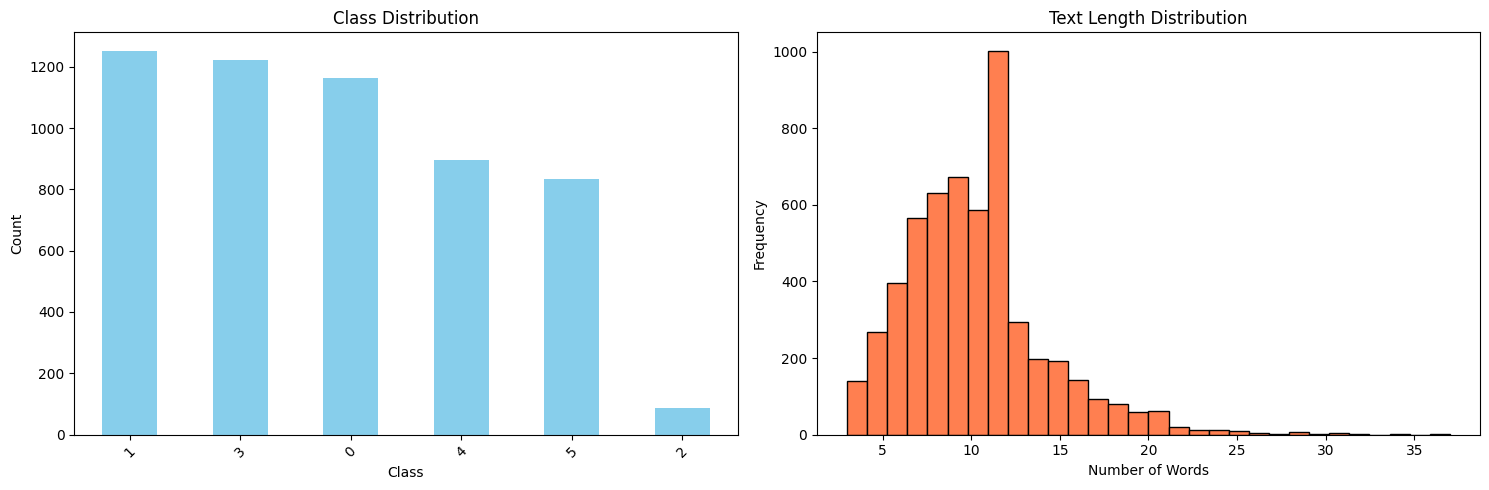

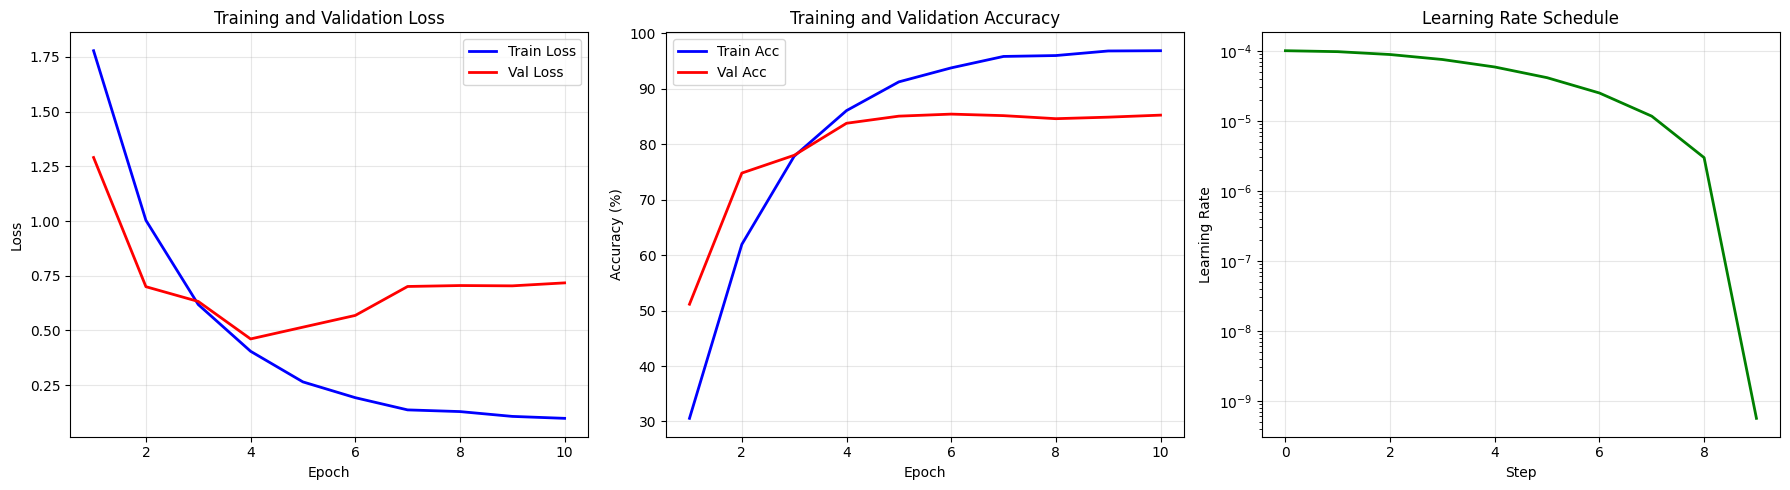

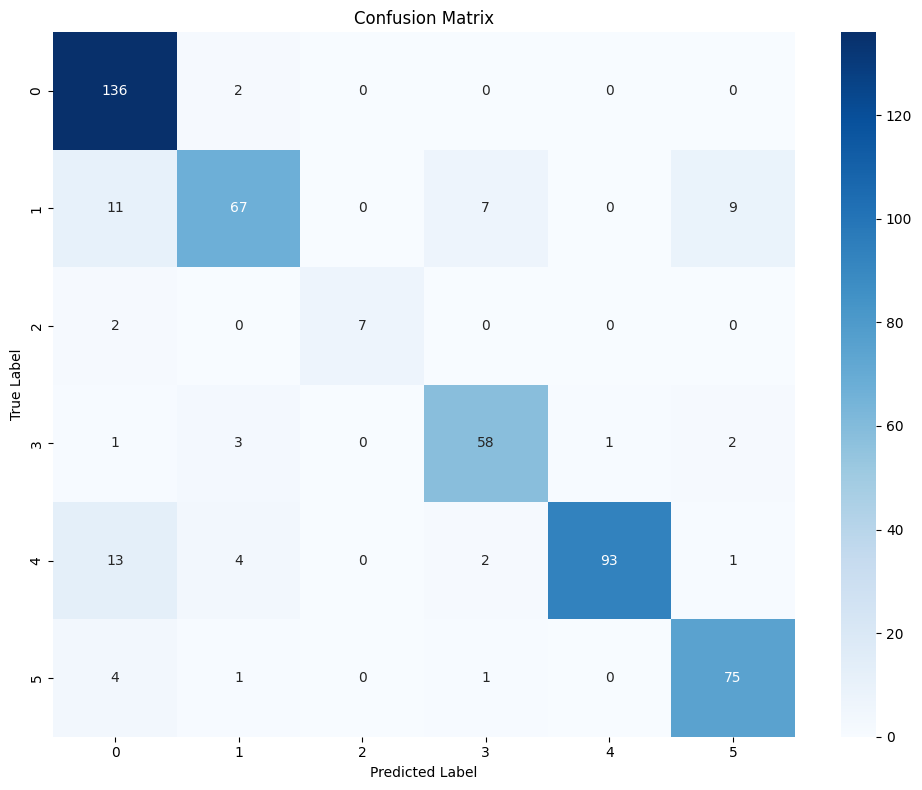

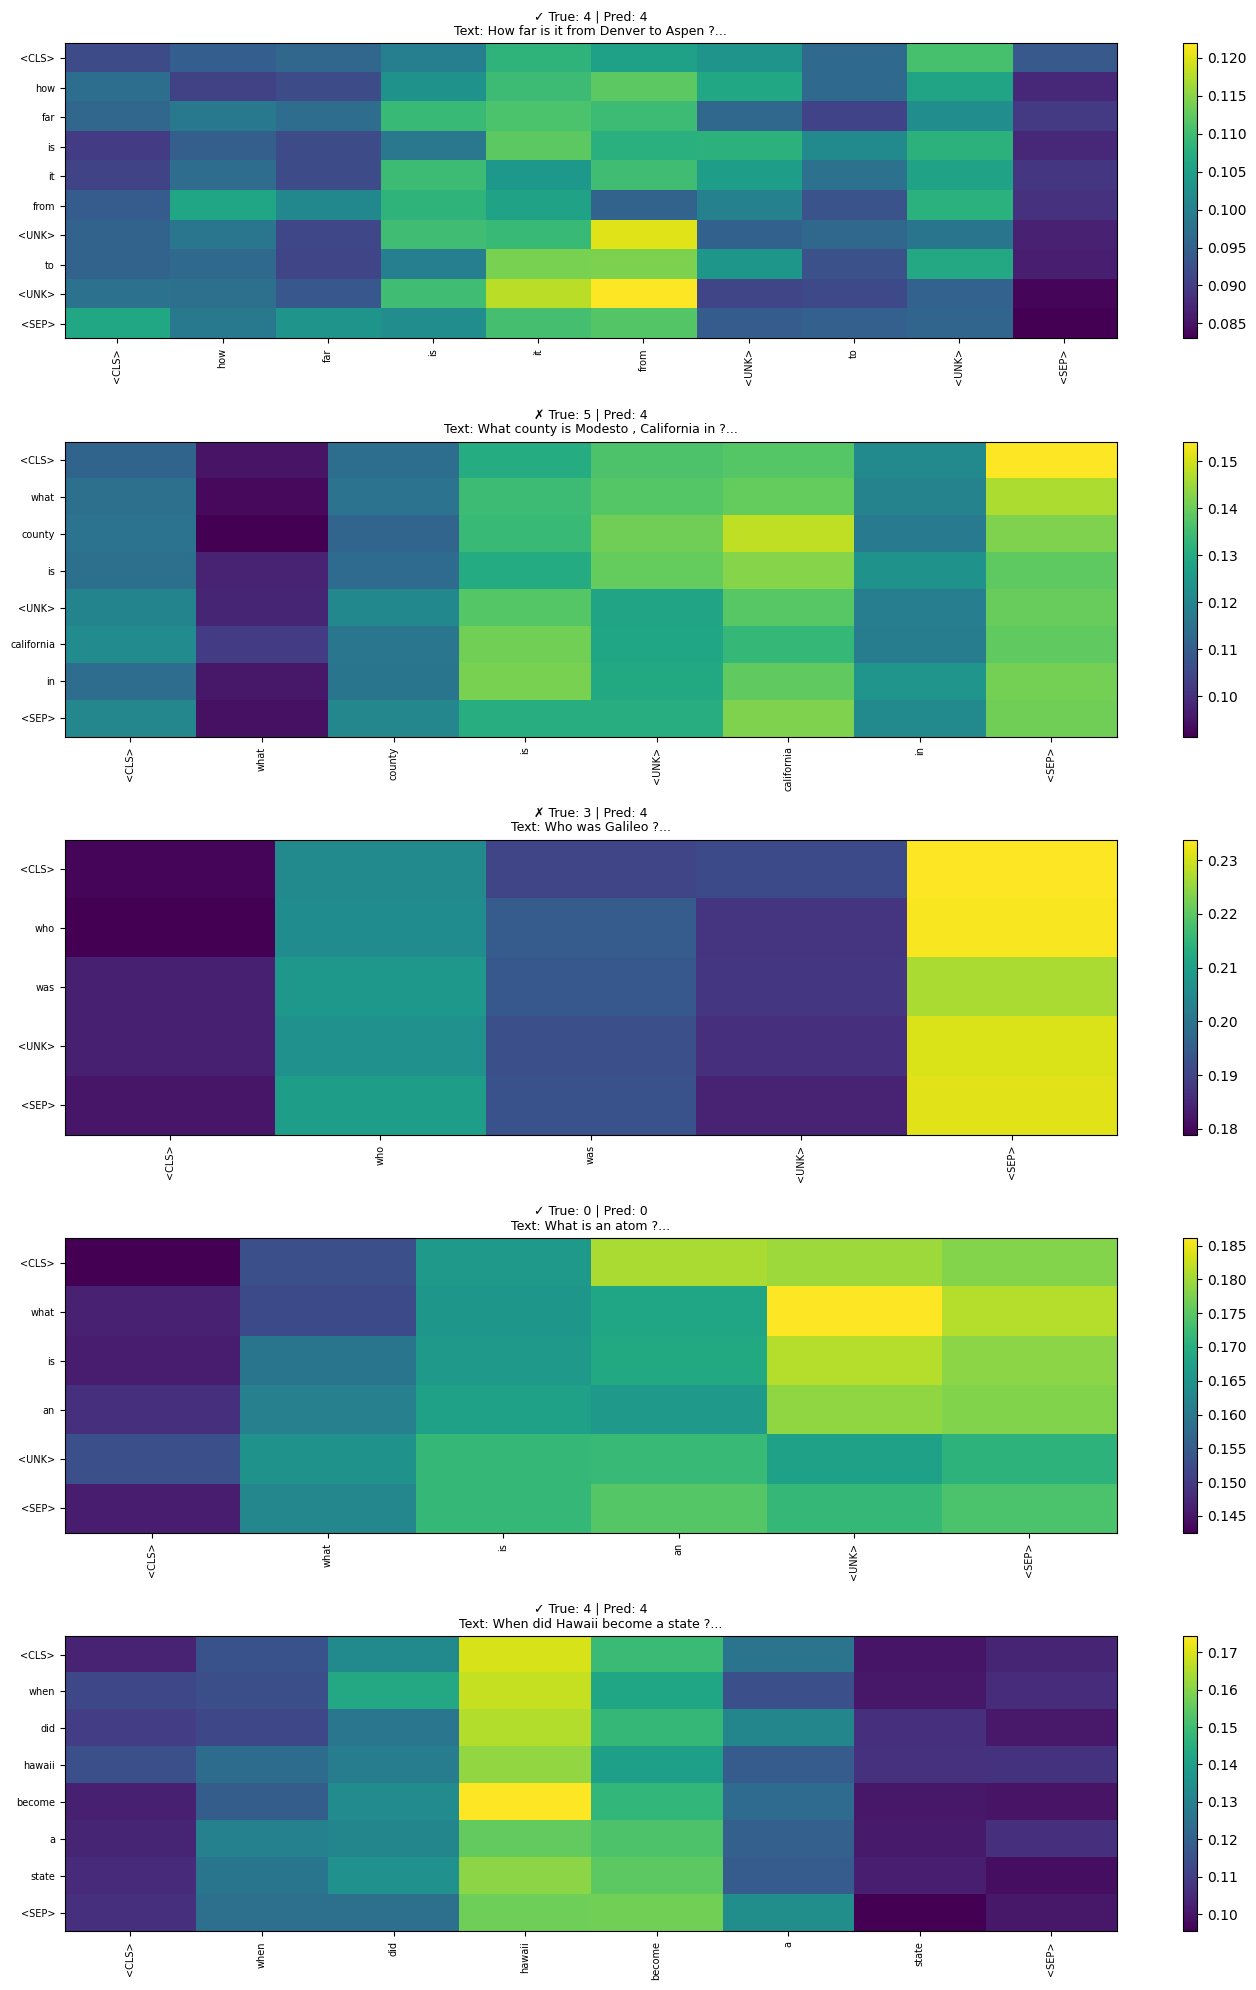

In [29]:
if __name__ == "__main__":
    model, processor, trainer, results = main()